# Install library

In [149]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from tensorflow.keras.layers import Input, Dense, Conv2D, Activation
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

## Dataset preprocessing and EDA

In [251]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() # load data
x_train,x_test = x_train.astype('float32')/255.0,x_test.astype('float32')/255.0 # normalization
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(50000, 3072)
(10000, 3072)


In [252]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 3072)
(50000, 1)
(10000, 3072)
(10000, 1)


In [253]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [254]:
# No method on keras to get cifar10 category label name by categoly label?
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

bird_ind = np.where(cifar10_labels=='bird')
deer_ind = np.where(cifar10_labels=='deer')
truck_ind = np.where(cifar10_labels=='truck')

In [255]:
remove_num = 2500
counter = 0
train_num = len(y_train) - remove_num * 3 # for 3 classes
x_train_removed =  np.zeros(x_train.shape)[:train_num]
y_train_removed =  np.zeros(y_train.shape)[:train_num]

# bird, deer, truck labeld data is removed by 2500
bird_limit, deer_limit, truck_limit = 0, 0, 0
for i, label in enumerate(y_train):
    if (label != bird_ind) & (label != deer_ind) & (label != truck_ind):
        x_train_removed[counter] = x_train[i]
        y_train_removed[counter] = y_train[i]
        counter += 1
    else:
        if label == bird_ind:
            if bird_limit < 2500:
                bird_limit += 1
                x_train_removed[counter] = x_train[i]
                y_train_removed[counter] = y_train[i]
                counter += 1
                continue
            else: continue
        if label == deer_ind:
            if deer_limit < 2500:
                deer_limit += 1
                x_train_removed[counter] = x_train[i]
                y_train_removed[counter] = y_train[i]
                counter += 1
                continue
            else: continue
        if label == truck_ind:
            if truck_limit < 2500:
                truck_limit += 1
                x_train_removed[counter] = x_train[i]
                y_train_removed[counter] = y_train[i]
                counter += 1
                continue
            else: continue

y_train_removed = np.array(y_train_removed, dtype='uint8')

In [256]:
print(x_train_removed.shape)
print(y_train_removed.shape)

(42500, 3072)
(42500, 1)


In [257]:
df = pd.DataFrame(y_train_removed.flatten())
df.value_counts()

8    5000
7    5000
6    5000
5    5000
3    5000
1    5000
0    5000
9    2500
4    2500
2    2500
dtype: int64

(array([5000., 5000., 2500., 5000., 2500., 5000., 5000., 5000., 5000.,
        2500.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

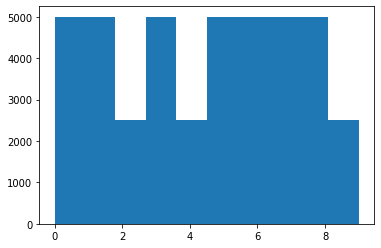

In [258]:
import matplotlib.pyplot as plt

# データ数をプロット
plt.hist(y_train_removed.flatten())

## AutoEncoder

In [137]:
# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
# input_img = tf.keras.Input(shape=(784,))
input_img = tf.keras.Input(shape=(3072,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
# decoded = layers.Dense(784, activation='sigmoid')(encoded)
decoded = layers.Dense(3072, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = tf.keras.Model(input_img, decoded)

# For encode
# This model maps an input to its encoded representation
encoder = tf.keras.Model(input_img, encoded)

# For encode
# This is our encoded (32-dimensional) input
encoded_input = tf.keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = tf.keras.Model(encoded_input, decoder_layer(encoded_input))

In [142]:
# hyperparameters
batch_size = 32
epochs = 50
saveDir = "./model/"

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
chkpt = saveDir + 'AE_Cifar10.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = autoencoder.fit(x_train_removed, x_train_removed,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, x_test),
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)

Epoch 1/50
1316/1329 [============================>.] - ETA: 0s - loss: 0.6344
Epoch 00001: val_loss improved from inf to 0.62336, saving model to ./model\AE_Cifar10.01-0.63-0.62.hdf5
1329/1329 [==============================] - 3s 2ms/step - loss: 0.6342 - val_loss: 0.6234
Epoch 2/50
1329/1329 [==============================] - ETA: 0s - loss: 0.6174
Epoch 00002: val_loss improved from 0.62336 to 0.61583, saving model to ./model\AE_Cifar10.02-0.62-0.62.hdf5
1329/1329 [==============================] - 2s 2ms/step - loss: 0.6174 - val_loss: 0.6158
Epoch 3/50
1322/1329 [============================>.] - ETA: 0s - loss: 0.6095
Epoch 00003: val_loss improved from 0.61583 to 0.60842, saving model to ./model\AE_Cifar10.03-0.61-0.61.hdf5
1329/1329 [==============================] - 2s 2ms/step - loss: 0.6095 - val_loss: 0.6084
Epoch 4/50
1294/1329 [============================>.] - ETA: 0s - loss: 0.6059
Epoch 00004: val_loss improved from 0.60842 to 0.60756, saving model to ./model\AE_Cifar

In [143]:
autoencoder.summary()

Model: "functional_129"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                98336     
_________________________________________________________________
dense_15 (Dense)             (None, 3072)              101376    
Total params: 199,712
Trainable params: 199,712
Non-trainable params: 0
_________________________________________________________________


In [144]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

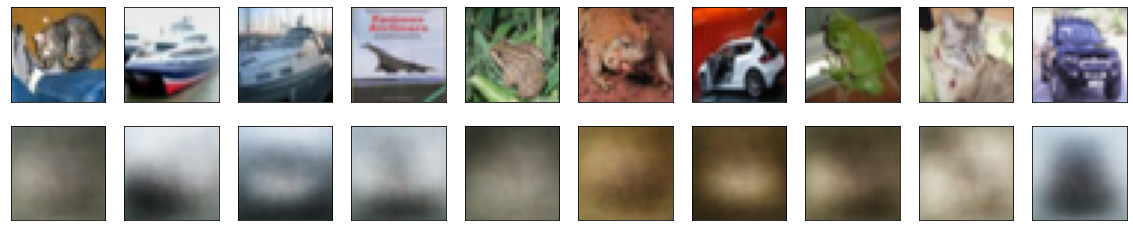

In [145]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [219]:
autoencoder.summary()

Model: "functional_129"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                98336     
_________________________________________________________________
dense_15 (Dense)             (None, 3072)              101376    
Total params: 199,712
Trainable params: 101,376
Non-trainable params: 98,336
_________________________________________________________________


## Classification

In [220]:
autoencoder._layers.pop() # autoencoder.layers.pop() doesn't work

In [221]:
autoencoder.layers

In [222]:
autoencoder.trainable = False

In [259]:
model = Sequential()
model.add(autoencoder)
model.add(Dense(10))
model.add(BatchNormalization())
model.add(Activation('softmax'))
adam = Adam(lr=1e-4)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])

In [260]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_129 (Functional)  (None, 3072)              98336     
_________________________________________________________________
dense_26 (Dense)             (None, 10)                30730     
_________________________________________________________________
batch_normalization_232 (Bat (None, 10)                40        
_________________________________________________________________
activation_231 (Activation)  (None, 10)                0         
Total params: 129,106
Trainable params: 30,750
Non-trainable params: 98,356
_________________________________________________________________


In [261]:
from tensorflow.keras.utils import plot_model, to_categorical

nb_classes = 10
y_train_removed = to_categorical(y_train_removed, nb_classes)
y_test = to_categorical(y_test, nb_classes)

history2=model.fit(x_train_removed,y_train_removed,batch_size=256,epochs=20,verbose=1)

Epoch 1/20
167/167 [==============================] - 1s 3ms/step - loss: 2.0600 - accuracy: 0.2647
Epoch 2/20
167/167 [==============================] - 1s 3ms/step - loss: 1.9918 - accuracy: 0.2993
Epoch 3/20
167/167 [==============================] - 0s 3ms/step - loss: 1.9837 - accuracy: 0.3043
Epoch 4/20
167/167 [==============================] - 0s 3ms/step - loss: 1.9828 - accuracy: 0.3020
Epoch 5/20
167/167 [==============================] - 0s 3ms/step - loss: 1.9751 - accuracy: 0.3062
Epoch 6/20
167/167 [==============================] - 0s 3ms/step - loss: 1.9742 - accuracy: 0.3074
Epoch 7/20
167/167 [==============================] - 0s 3ms/step - loss: 1.9689 - accuracy: 0.3089
Epoch 8/20
167/167 [==============================] - 0s 3ms/step - loss: 1.9647 - accuracy: 0.3096
Epoch 9/20
167/167 [==============================] - 0s 3ms/step - loss: 1.9600 - accuracy: 0.3121
Epoch 10/20
167/167 [==============================] - 0s 3ms/step - loss: 1.9564 - accuracy: 0.3140